<a href="https://colab.research.google.com/github/srh-mgdm/Countwithme/blob/main/COVID_19_Radiography_sareh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 - Upload kaggle.json from your local computer to Colab

from google.colab import files  # import Colab helper to upload files
uploaded = files.upload()       # open a dialog to choose kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Cell 2 - Automatically detect the uploaded kaggle.json file

import os
import shutil # High-level file operations (move, copy, delete); used here to relocate kaggle.json securely

# Find ANY file that contains "kaggle" and ends with .json
uploaded_files = [f for f in os.listdir() if f.startswith("kaggle") and f.endswith(".json")]

if len(uploaded_files) == 0:
    raise FileNotFoundError(
        "No kaggle.json file found.\n"
        "Please go back to **Cell 1**, run it, and upload your kaggle.json file."
    )

kaggle_file = uploaded_files[0]  # pick the first match
print("Detected Kaggle file:", kaggle_file)

# Create .kaggle directory if missing
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the detected file to the correct location
shutil.move(kaggle_file, "/root/.kaggle/kaggle.json")

# set permissions using octal format (0o600 = read/write for owner only)
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("Kaggle API key installed successfully.")

Detected Kaggle file: kaggle.json
Kaggle API key installed successfully.


In [ ]:
# Cell 3 - Download Kaggle Dataset (COVID-19 Radiography Database)

# Create a directory to store the dataset
# We use -p so the command doesn't fail if the folder already exists
!mkdir -p data/covid_radiography

# Download the dataset from Kaggle using the Kaggle API
# -d : dataset identifier on Kaggle
# -p : path where the zip file will be saved
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p data/covid_radiography

# Unzip the downloaded file
import zipfile
import os

# Automatically detect ZIP file
zip_files = [f for f in os.listdir("data/covid_radiography") if f.endswith(".zip")]

if len(zip_files) == 0:
    raise FileNotFoundError("No ZIP file found in data/covid_radiography")

zip_path = os.path.join("data/covid_radiography", zip_files[0])
print("Detected ZIP file:", zip_path)

# Extract all files into the target directory
# "with" opens the ZIP file safely (auto-closes it), "r" means read-only mode,
# zip_ref is the temporary reference (handle) for the opened ZIP file,
# and extractall() unpacks ALL content of the ZIP into the specified folder.
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("data/covid_radiography")

print("Extraction completed.")

# Automatically detect the dataset's main folder (the unzipped folder)
extracted_folders = [
    f for f in os.listdir("data/covid_radiography")
    if os.path.isdir(os.path.join("data/covid_radiography", f))
    and not f.endswith(".zip")
]

if len(extracted_folders) == 0:
    raise FileNotFoundError("No extracted dataset folder found inside data/covid_radiography")

main_folder = extracted_folders[0]
main_path = os.path.join("data/covid_radiography", main_folder)

print("Automatically detected main dataset folder:", main_folder)

# List the subfolders inside the dataset (these should be the 4 classes)
print("Subfolders inside the dataset:")
print(os.listdir(main_path))

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 96% 747M/778M [00:03<00:00, 186MB/s]
100% 778M/778M [00:05<00:00, 160MB/s]
Detected ZIP file: data/covid_radiography/covid19-radiography-database.zip
Extraction completed.
Automatically detected main dataset folder: COVID-19_Radiography_Dataset
Subfolders inside the dataset:
['Lung_Opacity.metadata.xlsx', 'Viral Pneumonia', 'Normal.metadata.xlsx', 'COVID.metadata.xlsx', 'Lung_Opacity', 'README.md.txt', 'Viral Pneumonia.metadata.xlsx', 'Normal', 'COVID']


In [ ]:
# Cell 4 - Build a *raw* DataFrame

import os
import pandas as pd
from PIL import Image   # lightweight for reading image sizes only

print("Using dataset folder:", main_path, "\n")


# Detect class folders (COVID, Normal, Lung_Opacity, Viral Pneumonia)
class_folders = [
    f for f in os.listdir(main_path)
    if os.path.isdir(os.path.join(main_path, f))
]

print("Detected class folders:", class_folders , "\n")

rows = []

for cls in class_folders:
    images_dir = os.path.join(main_path, cls, "images")  # we only explore 'images' subfolder

    for fname in os.listdir(images_dir):
        fpath = os.path.join(images_dir, fname)

        # We only skip directories; we keep *all* files, whatever the extension
        if os.path.isfile(fpath):
            root, ext = os.path.splitext(fname)  # ext gives '.png', '.jpg', etc.
             # extract image size (H, W)
            try:
                with Image.open(fpath) as img:
                    width, height = img.size   # PIL returns (W, H)
            except:
                width, height = None, None     # in case corrupted file exists
            rows.append({
                "filepath": fpath,
                "filename": root,
                "ext": ext.lower(),  # for easier analysis
                "label": cls,
                "width": width,
                "height": height
            })

df_images_raw = pd.DataFrame(rows)
df_images_raw.info()
df_images_raw.head()

Using dataset folder: data/covid_radiography/COVID-19_Radiography_Dataset 

Detected class folders: ['Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  21165 non-null  object
 1   filename  21165 non-null  object
 2   ext       21165 non-null  object
 3   label     21165 non-null  object
 4   width     21165 non-null  int64 
 5   height    21165 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 992.2+ KB


,filepath,filename,ext,label,width,height
0,data/covid_radiography/COVID-19_Radiography_Da...,Viral Pneumonia-224,.png,Viral Pneumonia,299,299
1,data/covid_radiography/COVID-19_Radiography_Da...,Viral Pneumonia-813,.png,Viral Pneumonia,299,299
2,data/covid_radiography/COVID-19_Radiography_Da...,Viral Pneumonia-1101,.png,Viral Pneumonia,299,299
3,data/covid_radiography/COVID-19_Radiography_Da...,Viral Pneumonia-685,.png,Viral Pneumonia,299,299
4,data/covid_radiography/COVID-19_Radiography_Da...,Viral Pneumonia-1053,.png,Viral Pneumonia,299,299


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_images_raw)

MessageError: Error: credential propagation was unsuccessful

Total number of images: 21165 

Number of images and percentage per class:

                 n_images    percent
label                               
Normal              10192  48.154973
Lung_Opacity         6012  28.405386
COVID                3616  17.084810
Viral Pneumonia      1345   6.354831


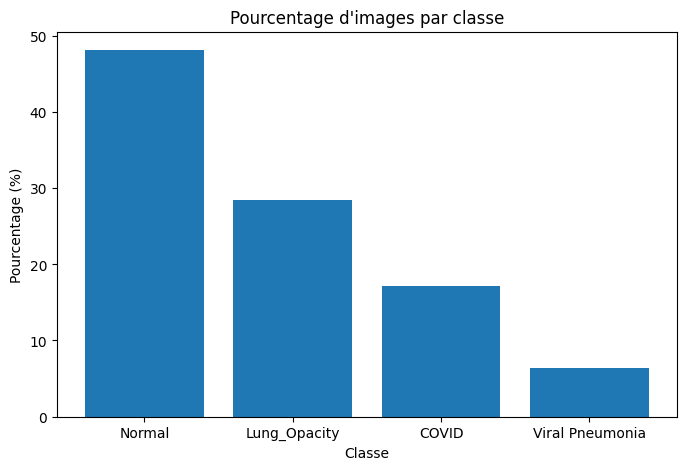

In [ ]:
# Cell 5 — Basic statistics: number and percentage of images per class with visualization

import matplotlib.pyplot as plt

# Count number of images per class
class_counts = df_images_raw["label"].value_counts()

# Total number of images
total_images = len(df_images_raw)

# Build a small summary DataFrame
df_class_stats = pd.DataFrame({
    "n_images": class_counts,
    "percent": (class_counts / total_images) * 100
})

print("Total number of images:", total_images, "\n")
print("Number of images and percentage per class:\n")
print(df_class_stats)


# Simple bar plot of class percentages

percentages = df_class_stats["percent"]

plt.figure(figsize=(8, 5))
plt.bar(percentages.index, percentages.values)

plt.title("Pourcentage d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Pourcentage (%)")

plt.show()

        height    width
count  21165.0  21165.0
mean     299.0    299.0
std        0.0      0.0
min      299.0    299.0
25%      299.0    299.0
50%      299.0    299.0
75%      299.0    299.0
max      299.0    299.0


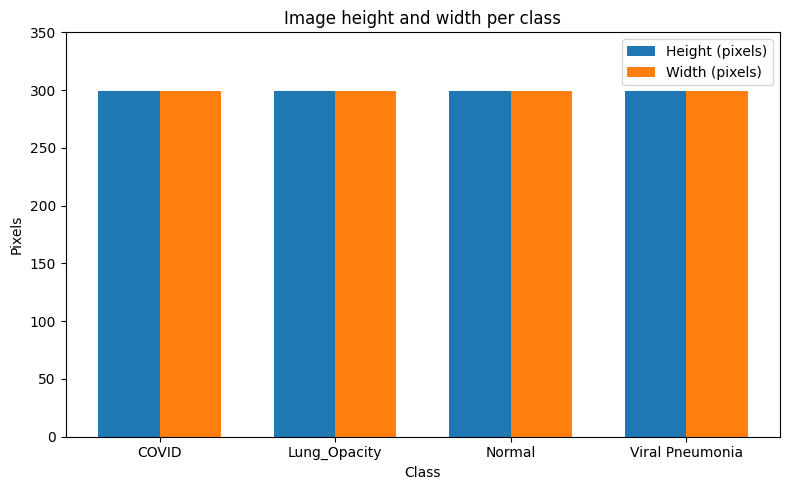

In [ ]:
# Cell 6 - Basic statistics of image sizes

print(df_images_raw[["height","width"]].describe())

# Bar plot: height and width per class

import matplotlib.pyplot as plt
import numpy as np

# 1) Compute average height and width per class (here they are all 299, but we do it cleanly)
class_sizes = df_images_raw.groupby("label")[["height", "width"]].mean()
classes = class_sizes.index.tolist()          # list of class names
heights = class_sizes["height"]      # height values (pixels)
widths  = class_sizes["width"]       # width values (pixels)

x = np.arange(len(classes))          # x positions for the 4 classes
bar_width = 0.35                     # width of each bar

plt.figure(figsize=(8, 5))

# Bar for height
plt.bar(x - bar_width/2, heights, width=bar_width, label="Height (pixels)")

# Bar for width
plt.bar(x + bar_width/2, widths, width=bar_width, label="Width (pixels)")

# Axis labels and title
plt.xlabel("Class")                           # X-axis: class names
plt.ylabel("Pixels")                          # Y-axis: pixel value (e.g., 299)
plt.title("Image height and width per class") # Figure title

# Put class names under the ticks
plt.xticks(x, classes)

# Small margin on top of bars
plt.ylim(0, 350)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7 - Répartition des extensions

print("Répartition des extensions :")
df_images_raw["ext"].value_counts()

Répartition des extensions :


,count
ext,
.png,21165


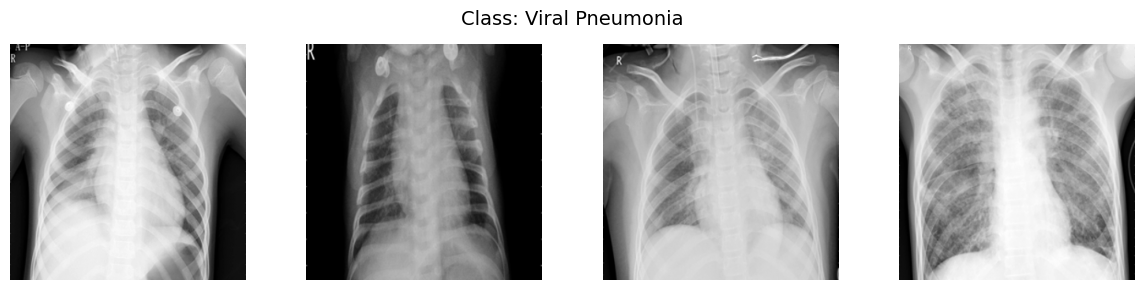

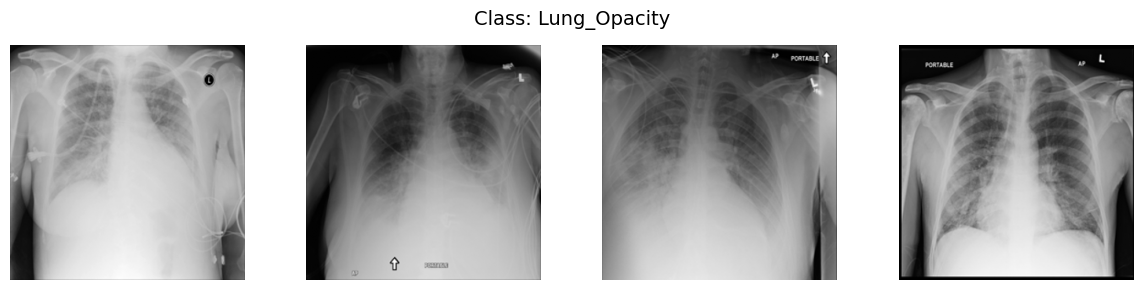

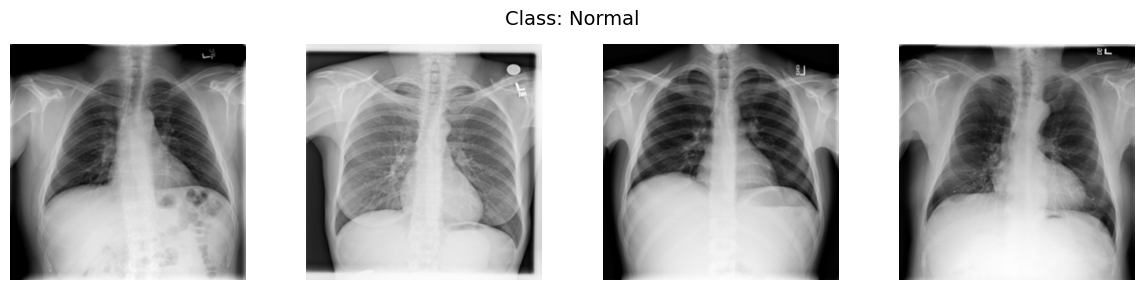

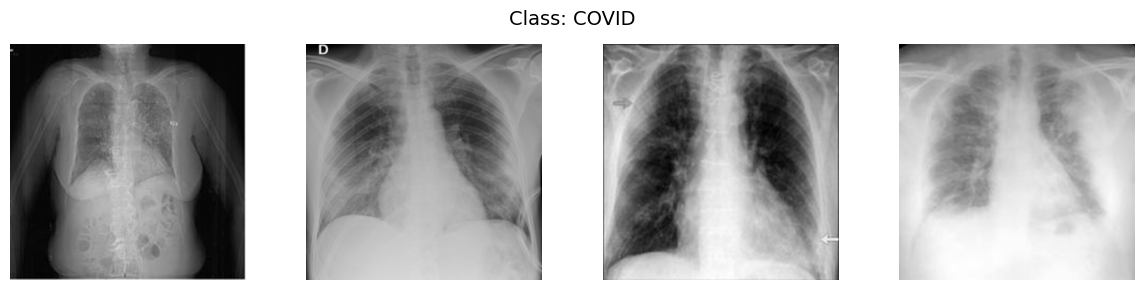

In [ ]:
# Cell 8 — Simple visualization: show the first 4 images from each class
# This cell displays 4 sample X-ray images per class in clean grayscale,
# with titles placed just above the images (small vertical gap).

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

for cls in df_images_raw["label"].unique():
    # Select the first 4 images of this class
    subset = df_images_raw[df_images_raw["label"] == cls].head(4)

    # Create a horizontal figure for this class
    fig = plt.figure(figsize=(12, 3))

    # Title placed close to the top of the images
    fig.suptitle(f"Class: {cls}", fontsize=14, y=0.95)  # y controls vertical position of title

    # Loop over the 4 selected rows
    # enumerate(...) gives (index, row)
    # subset.itertuples() returns each DataFrame row as a lightweight Python object,
    # allowing access like: row.filepath, row.label, etc.
    for i, row in enumerate(subset.itertuples(), 1):
        img = Image.open(row.filepath)   # Read image with PIL, Image.open() returns a PIL Image object (NOT a NumPy array)
        img_array = np.array(img)        # Convert PIL image to NumPy array for imshow()

        # Create a subplot inside the figure.
        # add_subplot(1, 4, i) means:
        # - 1 row of subplots
        # - 4 columns of subplots
        # - place this image in position i (1 to 4).
        # Returns an Axes object ('ax') that represents one subplot area.
        ax = fig.add_subplot(1, 4, i)
        ax.imshow(img, cmap="gray")            # Display the image, True grayscale display
        ax.axis("off")                         # No axes for a cleaner view

    # Automatically adjusts spacing between subplots to remove unnecessary gaps
    # and prevent titles / images / axes from overlapping. Makes the layout clean.
    fig.tight_layout()              #reduces padding inside the figure

    plt.show()